In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import os
import time
import sys
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [16]:
# tf.nn.softplus: log(1+e^x)

customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))

tf.Tensor([4.5417706e-05 6.7153489e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


In [6]:
# customized dense layer
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        """构建需要的参数"""
        self.kernel = self.add_weight(name = 'kernel', shape = (input_shape[1], self.units),
                                     initializer = 'uniform',
                                     trainable = True)
        self.bias = self.add_weight(name='bias', shape=(self.units,),
                                   initializer = 'zeros',
                                   trainable = True)
        super(CustomizedDenseLayer, self).build(input_shape)
    def call(self, x):
        """完成正向计算"""
        return self.activation(x @ self.kernel + self.bias)

model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu', input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1),
    customized_softplus,
])

model.summary()
model.compile(loss='mean_squared_error', optimizer='sgd')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer (Cust (None, 30)                270       
_________________________________________________________________
customized_dense_layer_1 (Cu (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train_scaled, y_train,
                   validation_data = (x_valid_scaled, y_valid),
                   epochs = 100,
                   callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 123us/sample - loss: 1.0818 - val_loss: 0.6347
Epoch 2/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.5494 - val_loss: 0.5409
Epoch 3/100
11610/11610 [==============================] - 1s 63us/sample - loss: 0.4866 - val_loss: 0.5059
Epoch 4/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.4579 - val_loss: 0.4827
Epoch 5/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.4549 - val_loss: 0.4666
Epoch 6/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.4419 - val_loss: 0.6312
Epoch 7/100
11610/11610 [==============================] - 1s 101us/sample - loss: 0.4506 - val_loss: 0.4478
Epoch 8/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4241 - val_loss: 0.4721
Epoch 9/100
11610/11610 [==============================] - 1s 81us/sample - loss: 0.4

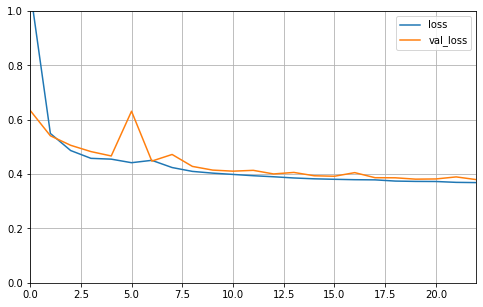

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)